# The goal of this competition is to create an algo that recognize different digit giving a picture. 
Throught this notebook, we will see of to preprocess data from a Pandas Dataframe to a list of array. And then 2 methods : create our own CNN model, use fine tuning on pre trained VGG16 model

# We import dataset and modules

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import utilities
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
# convo model
from tensorflow import keras
from keras import utils
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

train = pd.read_csv('/Users/avicenne/Documents/python/digit-recognizer/train.csv')
test = pd.read_csv('/Users/avicenne/Documents/python/digit-recognizer/test.csv')
print("number of classes :", train.label.unique())
train.head(3)

number of classes : [1 0 4 7 3 5 8 9 2 6]


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocess
Here we save labels and drop it from the train dataset

In [3]:
# we save labels
digit = np.array(train.label, 
                   dtype=np.float64)
df_train = train.drop(['label'], axis=1)

We can have a look on images

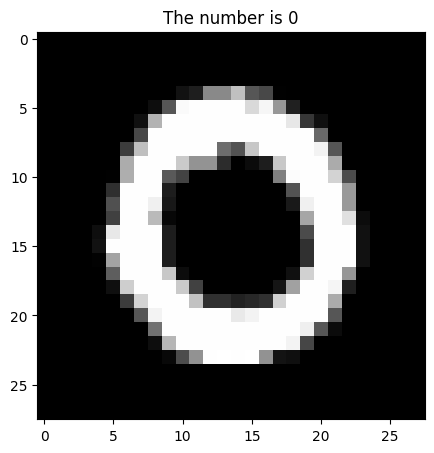

In [4]:
plt.figure(figsize=(5,8))
plt.imshow(np.array(df_train.iloc[1].tolist()).ravel().reshape(28,28),
               cmap='gray')
plt.title(f'The number is { df_train.iloc[1,0] }')
plt.show()

Here we will extract each line of the dataset to convert it in an array, in order to reconstruct the original image : shape sqrt(784) --> (28, 28)

And then we normalize with /=255.0

In [5]:
X_train = np.array([np.array(df_train.iloc[i].tolist()).ravel().reshape(28,28) for i in range(len(df_train))], 
                   dtype=np.float64)
X_test = np.array([np.array(test.iloc[i].tolist()).ravel().reshape(28,28) for i in range(len(test))], 
                  dtype=np.float64)

X_train /= 255.0
X_test /= 255.0


In [6]:
print(X_train.shape)
print(digit.shape)
print(X_train.dtype)
print(digit.dtype)
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(digit)))

(42000, 28, 28)
(42000,)
float64
float64
False
False


# We build our own convo model

In [7]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D(2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPool2D(2))
model . add ( layers . BatchNormalization () )
model.add(layers.Dropout(0.2))
model . add ( layers . Flatten () )
model . add ( layers . Dense ( units =64 , activation = "relu" ) )
model . add ( layers . Dense ( units =10 , activation = "softmax" ) )

print(model.summary())

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])


/Users/avicenne/anaconda3/envs/ultra/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,090 (398.79 KB)

 Trainable params: 101,834 (397.79 KB)

 Non-trainable params: 256 (1.00 KB)

None


we train

In [8]:
history=model.fit(X_train, digit,validation_split=0.2, epochs=1)

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8924 - loss: 0.3719 - val_accuracy: 0.9776 - val_loss: 0.0710


# Some data visualization on the evolution of accuracy and val accuracy

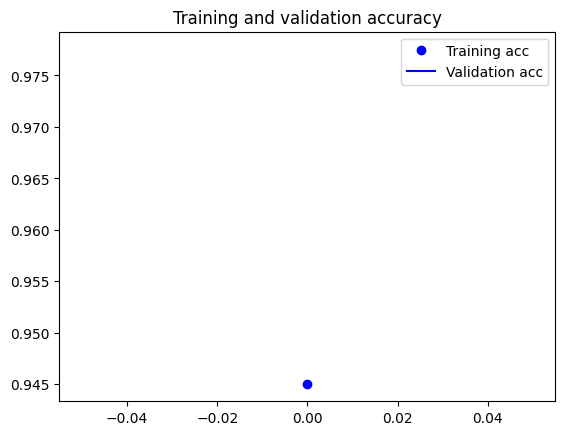

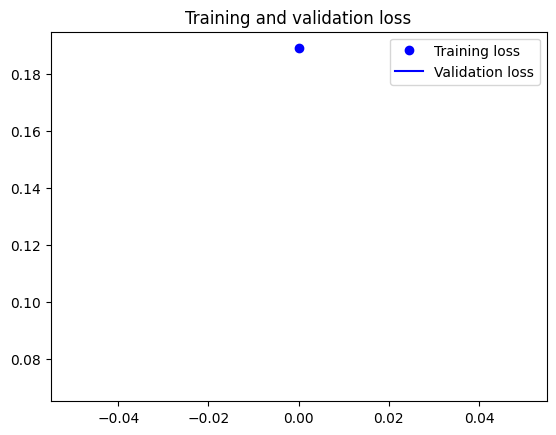

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Finally we can made our prediction

In [10]:
labels=[i for i in range(10)]

pred=model.predict(X_test)
index=np.argmax(pred,axis=1)
pred=[labels[i] for i in index]

875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Have a look on the result

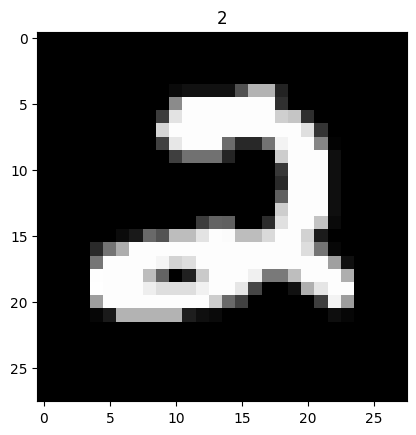

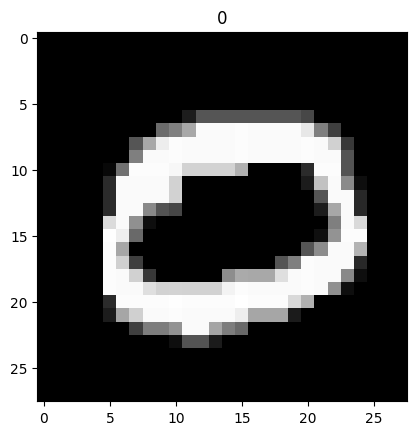

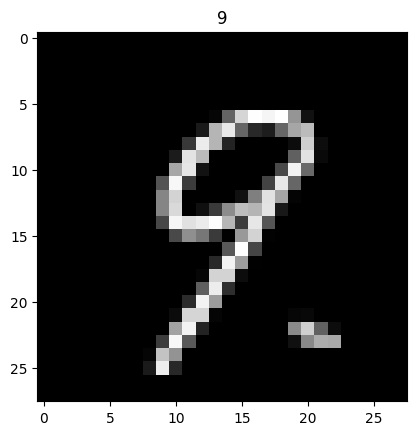

In [11]:
for i, value in enumerate(X_test[:3]):
    plt.imshow(value,cmap='gray')
    plt.title(pred[i])
    plt.show()

save the dataframe

In [12]:
"""df=pd.DataFrame({'ImageId': [i for i in range(1, len(test)+1)]})
df['Label']=pred
df.to_csv('submission.csv',index=False)"""

"df=pd.DataFrame({'ImageId': [i for i in range(1, len(test)+1)]})\ndf['Label']=pred\ndf.to_csv('submission.csv',index=False)"

# Fine tuning

Here we will use the pretrained model VGG16 in ordre to try to improve our precedent result

We need to provide 3D images with a minimum shape of 32

In [13]:
X_train_tune = []
for i in range(len(df_train)):
    image = np.array(df_train.iloc[i].tolist()).ravel().reshape(28,28).astype('float32')
    # put 3 chanels
    image_resized = cv2.resize(image, (32, 32))
    image_resized = np.stack((image_resized,)*3, axis=-1)
    X_train_tune.append(image_resized)

X_train_tune = np.array(X_train_tune)
X_train_tune /= 255.0


We separate for ressource allocation issue on kaggle notebook

In [14]:
X_test_tune = []
for j in range(len(test)):
    image = np.array(test.iloc[j].tolist()).ravel().reshape(28,28).astype('float32')
    # put 3 chanels
    image_resized = cv2.resize(image, (32, 32))
    image_resized = np.stack((image_resized,)*3, axis=-1)
    X_test_tune.append(image_resized)
    
X_test_tune = np.array(X_test_tune)
X_test_tune /= 255.0

we import VGG16 model

In [15]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary

<bound method Model.summary of <Sequential name=sequential_1, built=False>>

we froze almost all the convolutional block of the model in order to keep the most valuable part of the VGG16 which had been pretrained. We don't want to lose all the pretrained weight of the model

In [17]:
# we only activate the block 5

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
conv_base.summary

<bound method Model.summary of <Functional name=vgg16, built=True>>

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

history=model.fit(X_train_tune, digit,validation_split=0.2,
                  epochs=10, batch_size=32)

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 183s 173ms/step - acc: 0.8370 - loss: 0.6729 - val_acc: 0.9758 - val_loss: 0.0792
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 188s 179ms/step - acc: 0.9790 - loss: 0.0672 - val_acc: 0.9823 - val_loss: 0.0565
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 188s 179ms/step - acc: 0.9830 - loss: 0.0513 - val_acc: 0.9855 - val_loss: 0.0458
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 201s 191ms/step - acc: 0.9876 - loss: 0.0406 - val_acc: 0.9860 - val_loss: 0.0434
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 197s 188ms/step - acc: 0.9885 - loss: 0.0354 - val_acc: 0.9862 - val_loss: 0.0408
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 203s 194ms/step - acc: 0.9898 - loss: 0.0328 - val_acc: 0.9882 - val_loss: 0.0361
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 199s 190ms/step - acc: 0.9917 - loss: 0.0260 - val_acc: 0.9886 - val_loss: 0.0389
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 208s 198ms/step - acc: 0.9931 - loss: 0.0215 - val_acc: 0.9918 - val_loss: 0.0301
Epoch 9/

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

KeyError: 'accuracy'

we save the result

In [21]:
labels=[i for i in range(10)]

pred=model.predict(X_test_tune)
index=np.argmax(pred,axis=1)
pred=[labels[i] for i in index]

df=pd.DataFrame({'ImageId': [i for i in range(1, len(test)+1)]})
df['Label']=pred
df.to_csv('/Users/avicenne/Documents/python/digit-recognizer/submission.csv',index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step
